# 1. Import data

## 1.1 Load AG News data from FastAi repo in local directory
https://registry.opendata.aws/fast-ai-nlp/

In [1]:
train_file = '../news_data/train.csv'
test_file = '../news_data/test.csv'

In [2]:
import pandas as pd
import numpy as np
import os

In [59]:
def load_data(file):
    columns = ['topic', 'head', 'body']
    df = pd.read_csv(file, header=None)
    df.columns = columns
    return df

### Combine datasets to preprocess together

In [ ]:
train = load_data(train_file)
train['set'] = np.array([1,]*len(train))
print(f'Train set: {len(train)}')

test = load_data(test_file)
test['set'] = np.array([0,]*len(test))
print(f'Test set: {len(test)}')

ratio = round(len(test)/(len(train)+len(test)), 3)
print(f'Test size ratio = {ratio}')
df = pd.concat([train, test])

In [5]:
df.head()

,topic,head,body,set
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1


Topic labels:
1. World
2. Sports
3. Business
4. Sci/Tech

# 2. Preprocessing news body data

## 2.1 Remove punctuations and capitalizations

This step will be combined with the following

## 2.2 Remove stopwords, stem words, and obtain bags of words 

In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def process_text(text):
    sw = stopwords.words('english')  + ['reuters', 'afp']
    stemmer = SnowballStemmer('english')
    text = text.lower()
    text = re.sub('[,./?!-;:]', '', text)
    text = re.sub('\n' , ' ' , text)
    text = re.sub('\\\\' , ' ' , text)
    text_list = [stemmer.stem(i) for i in text.split(' ') if i and i not in sw]
    return {word:text_list.count(word) for word in text_list}

In [7]:
df['word_bag'] = df.body.map(process_text)
df.head()

,topic,head,body,set,word_bag
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1,"{'shortsel': 1, 'wall': 1, 'street': 1, 'dwind..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1,"{'privat': 1, 'invest': 1, 'firm': 1, 'carlyl'..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1,"{'soar': 1, 'crude': 1, 'price': 1, 'plus': 1,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1,"{'author': 1, 'halt': 1, 'oil': 2, 'export': 1..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1,"{'tearaway': 1, 'world': 1, 'oil': 1, 'price':..."


## 2.3 Explore text bodies

In [8]:
total_word_bag = {}
for bag in df.word_bag.values:
    for word in bag:
        if word not in total_word_bag:
            total_word_bag[word] = bag[word]
        else:    
            total_word_bag[word] += bag[word]
total_word_bag = dict(sorted(total_word_bag.items(), key=lambda x:x[1], reverse=True))

<h2 style="color:red;">Could've used a word cloud but the package is not compactible with python 3.9 atm.. :(</h2>

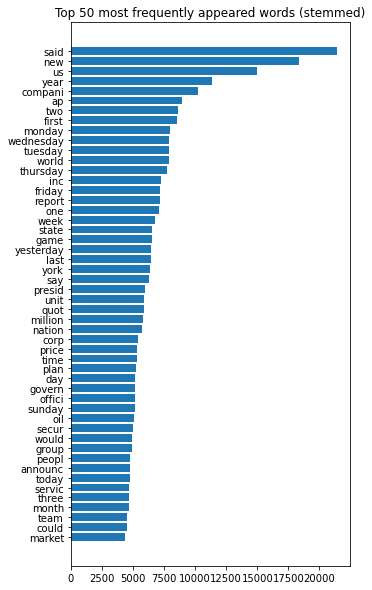

In [9]:
import matplotlib.pyplot as plt
top50 = list(total_word_bag.items())[:50]
plt.figure(figsize=[5,10])
plt.barh(*zip(*top50))
plt.gca().invert_yaxis()
plt.title('Top 50 most frequently appeared words (stemmed)')
plt.show()

Using stopwords from NLTK, we've managed to removed quite a number of words that do not carry information like 'I', 'you', 'myself' etc.

However, there are still plenty of generic looking words like 'said', 'reuter' or 'year' that can appear in all topics.

It may be too difficult to identity all of these by eyeballing, but we can remove some of these words using TF-IDF method.

## 2.4 Compute TF-IDF and add common words to stopword list

TF-IDF is a score assigned to each word in a document that meansures how frequently the word appear in the document (TF: term frequency) as well as how rare this word appears in all the other documents in the corpus (IDF: inverse document frequency)<br><br>
For example, the term "Dirichlet" is probably going to appear quite frequently in a document about topic clustering, but unlikely to appear in articles in any other topics. This give the word "Dirichlet" a high TF-IDF value in these documents. <br><br>Alternatively, words like "alternatively" can indeed occur very frequently in documents about topic clustering, but it is also likely to appear in any topic, so it will have a low TF-IDF value in most documents. 

In [10]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# NOPE.. COMPUTER NOT ENOUGH MEMORY
# Time to DIY

In [11]:
def tfidf(bag_list):
    def getTF(bag):
        total = float(sum(bag.values()))
        return {word:bag[word]/total for word in bag}

    def getIDF(bag_list):
        idfs = {}
        n = len(bag_list)
        for bag in bag_list:
            for word in bag:
                if word in idfs:
                    idfs[word] += 1
                else:
                    idfs[word] = 1
        return {word:np.log(n/idfs[word]) for word in idfs}
    
    tfidf_list = []
    idfs = getIDF(bag_list)
    
    for bag in bag_list:
        tf = getTF(bag)
        tfidf_list.append(
            {word:tf[word]*idfs[word] for word in tf}
        )
    return tfidf_list

In [12]:
df['tfidf'] = tfidf(df.word_bag.values)
df.head()

,topic,head,body,set,word_bag,tfidf
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1,"{'shortsel': 1, 'wall': 1, 'street': 1, 'dwind...","{'shortsel': 1.3322554201530896, 'wall': 0.576..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1,"{'privat': 1, 'invest': 1, 'firm': 1, 'carlyl'...","{'privat': 0.26507555235565955, 'invest': 0.25..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1,"{'soar': 1, 'crude': 1, 'price': 1, 'plus': 1,...","{'soar': 0.3351489679006488, 'crude': 0.281690..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1,"{'author': 1, 'halt': 1, 'oil': 2, 'export': 1...","{'author': 0.2317297884131842, 'halt': 0.29366..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1,"{'tearaway': 1, 'world': 1, 'oil': 1, 'price':...","{'tearaway': 0.653147536105157, 'world': 0.156..."


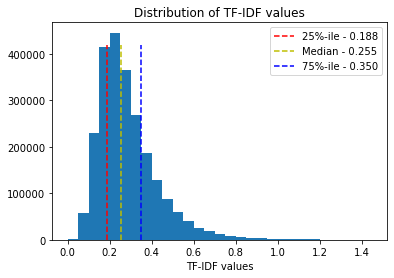

In [13]:
t = [j for i in df['tfidf'].values for j in i.values()]
plt.hist(t, bins=np.arange(0, 1.5, 0.05))

n = np.percentile(t, 25)
plt.plot([n, n],[0, 420000], 'r--', label=f'25%-ile - {n:.3f}')

m = np.median(t)
plt.plot([m, m],[0, 420000], 'y--', label=f'Median - {m:.3f}')

p = np.percentile(t, 75)
plt.plot([p, p],[0, 420000], 'b--', label=f'75%-ile - {p:.3f}')

plt.legend()
plt.title('Distribution of TF-IDF values')
plt.xlabel('TF-IDF values')
plt.show()

## 2.5 Dimensionality reduction: remove more words with low impact from data

We can reduce the number of words by keeping only the top 75%, 50%, or 25% in TF-IDF scores

In [14]:
cutoff = n
print(f'Cut-off TF-IDF value = {cutoff:.3f}')
# Remove all words in tfidf column if tf-idf of word < median value
df['tfidf'] = df['tfidf'].map(lambda x:{word:x[word] for word in x if x[word] > cutoff})
# Remove all words in word_bag column if word is not in tfidf column
df['word_bag'] = df[['word_bag', 'tfidf']].apply(lambda x: 
    {word:x[0][word] for word in x[0] if word in x[1].keys()}
    , axis=1)
df.head()

Cut-off TF-IDF value = 0.188


,topic,head,body,set,word_bag,tfidf
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1,"{'shortsel': 1, 'wall': 1, 'street': 1, 'dwind...","{'shortsel': 1.3322554201530896, 'wall': 0.576..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1,"{'privat': 1, 'invest': 1, 'firm': 1, 'carlyl'...","{'privat': 0.26507555235565955, 'invest': 0.25..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1,"{'soar': 1, 'crude': 1, 'price': 1, 'plus': 1,...","{'soar': 0.3351489679006488, 'crude': 0.281690..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1,"{'author': 1, 'halt': 1, 'oil': 2, 'export': 1...","{'author': 0.2317297884131842, 'halt': 0.29366..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1,"{'tearaway': 1, 'oil': 1, 'toppl': 1, 'record'...","{'tearaway': 0.653147536105157, 'oil': 0.19002..."


## 2.6 Tokenize words

Convert bag of words and tf-idf data from {'word1':2, 'word2':5} to [(1, 2), (2, 5)]

In [15]:
# Create a dictionary where each word is represent by its index
word_dictionary = [] 
for bag in df.word_bag.values:
    for word in bag:
        if word not in word_dictionary:
            word_dictionary.append(word)
word_dictionary[:10]

['shortsel',
 'wall',
 'street',
 'dwindl',
 'band',
 'ultracyn',
 'see',
 'green',
 'privat',
 'invest']

In [16]:
df['word_bag'] = df['word_bag'].map(lambda x:[(word_dictionary.index(word), x[word]) for word in x])
df['tfidf'] = df['tfidf'].map(lambda x:[(word_dictionary.index(word), x[word]) for word in x])
df.head()

,topic,head,body,set,word_bag,tfidf
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 1.3322554201530896), (1, 0.57633389777230..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1,"[(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (1...","[(8, 0.26507555235565955), (9, 0.2513989320700..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1,"[(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), ...","[(25, 0.3351489679006488), (26, 0.281690967534..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1,"[(41, 1), (42, 1), (43, 2), (44, 1), (45, 1), ...","[(41, 0.2317297884131842), (42, 0.293666663070..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1,"[(55, 1), (43, 1), (56, 1), (57, 1), (58, 1), ...","[(55, 0.653147536105157), (43, 0.1900280463206..."


# 3 Latent Dirichlet Allocation

Ok.. I forgot to convert the dictionary into a format gensim can read..

In [17]:
word_dictionary = {i:j for i, j in enumerate(word_dictionary)}
len(word_dictionary)

57159

So the cool thing about LDA is that we can not only apply to a tokenized set of documents (which is hard to model document length), we can also apply it to bag of words and even tf-idf features directly. We are going to do exactly the last two.

## 3.1 Create LDA model for bag of words

In [18]:
from gensim.models import LdaMulticore

lda_bow = LdaMulticore(df.word_bag, num_topics = 4, id2word=word_dictionary, passes=2, workers=3)

In [19]:
for id, topic in lda_bow.print_topics(-1):
    print(f'Topic (By LDA): {id} \nKey Words: {topic}')

Topic (By LDA): 0 
Key Words: 0.004*"coach" + 0.004*"point" + 0.003*"score" + 0.003*"footbal" + 0.003*"team" + 0.003*"win" + 0.003*"elect" + 0.003*"presid" + 0.003*"leagu" + 0.003*"cup"
Topic (By LDA): 1 
Key Words: 0.004*"baghdad" + 0.004*"quarter" + 0.003*"sale" + 0.003*"red" + 0.003*"drug" + 0.003*"game" + 0.003*"iraqi" + 0.003*"percent" + 0.003*"iraq" + 0.003*"retail"
Topic (By LDA): 2 
Key Words: 0.006*"oil" + 0.005*"palestinian" + 0.004*"space" + 0.004*"polic" + 0.004*"music" + 0.003*"isra" + 0.003*"kill" + 0.003*"china" + 0.003*"arafat" + 0.003*"gaza"
Topic (By LDA): 3 
Key Words: 0.004*"microsoft" + 0.004*"softwar" + 0.004*"search" + 0.004*"servic" + 0.004*"billion" + 0.003*"comput" + 0.003*"internet" + 0.003*"mobil" + 0.003*"phone" + 0.003*"compani"


Judging from the keywords, we can guess (Order may change as notebook re-runs):
<br>Topic 0 = Sports
<br>Topic 1 = Business
<br>Topic 2 = World
<br>Topic 3 = Sci/Tech

In [20]:
lda_tfidf = LdaMulticore(df.tfidf, num_topics = 4, id2word=word_dictionary, passes=2, workers=3)

In [21]:
for id, topic in lda_tfidf.print_topics(-1):
    print(f'Topic (By LDA): {id} \nKey Words: {topic}')

Topic (By LDA): 0 
Key Words: 0.003*"microsoft" + 0.003*"softwar" + 0.002*"comput" + 0.002*"phone" + 0.002*"mobil" + 0.002*"internet" + 0.002*"search" + 0.002*"wireless" + 0.002*"servic" + 0.002*"technolog"
Topic (By LDA): 1 
Key Words: 0.003*"point" + 0.002*"score" + 0.002*"coach" + 0.002*"cup" + 0.002*"team" + 0.002*"game" + 0.002*"champion" + 0.002*"footbal" + 0.002*"win" + 0.002*"season"
Topic (By LDA): 2 
Key Words: 0.003*"palestinian" + 0.003*"polic" + 0.002*"kill" + 0.002*"iraqi" + 0.002*"baghdad" + 0.002*"arafat" + 0.002*"iraq" + 0.002*"militari" + 0.002*"troop" + 0.002*"un"
Topic (By LDA): 3 
Key Words: 0.002*"union" + 0.002*"airlin" + 0.002*"european" + 0.002*"peoplesoft" + 0.002*"oracl" + 0.002*"nuclear" + 0.002*"iran" + 0.002*"oil" + 0.001*"bid" + 0.001*"court"


Judging from the keywords, we can guess (Order may change as notebook re-runs):
<br>Topic 0 = Sci/Tech
<br>Topic 1 = Sports
<br>Topic 2 = World
<br>Topic 3 = Business

## 3.2 Estimate LDA topics based on label frequency

Guessing from the key words is good if you actually know the meaning of each word. 

Now imagine you are a five-year old child who cannot understand big words like "business" or "sports," then, like any clueless five-year old child, you have to look at the distribution of the predicted topics against the labelled topics and find the most statisically probable label for each estimated topic.

In [28]:
def get_topic(model, words):
    itr = model[words]
    i = 0
    arg = 0
    mx = 0 # assume all values > 0 
    while i < len(itr):
        if itr[i][1] > mx:
            mx = itr[i][1]
            arg = i
        i += 1
    return arg

In [29]:
df['bow_pred'] = df.word_bag.map(lambda x: get_topic(lda_bow, x))
df['tfidf_pred'] = df.word_bag.map(lambda x: get_topic(lda_tfidf, x))

In [30]:
df.head()

,topic,head,body,set,word_bag,tfidf,bow_pred,tfidf_pred
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 1.3322554201530896), (1, 0.57633389777230...",2,3
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1,"[(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (1...","[(8, 0.26507555235565955), (9, 0.2513989320700...",3,3
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1,"[(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), ...","[(25, 0.3351489679006488), (26, 0.281690967534...",1,0
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1,"[(41, 1), (42, 1), (43, 2), (44, 1), (45, 1), ...","[(41, 0.2317297884131842), (42, 0.293666663070...",2,2
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1,"[(55, 1), (43, 1), (56, 1), (57, 1), (58, 1), ...","[(55, 0.653147536105157), (43, 0.1900280463206...",0,2


In [53]:
name_mapping = {1:'World', 2:'Sports', 3:'Business', 4:'Sci/Tech'}
def match_label(original_topic, predicted_topic, name_mapping):
    match_matrix = {}
    for i in range(len(original_topic)):
        label = original_topic[i]
        pred = predicted_topic[i]
        if label not in match_matrix:
            match_matrix[label] = np.zeros(4)
        match_matrix[label][pred] += 1
    match_matrix = pd.DataFrame(match_matrix).rename(mapper=name_mapping, axis=1)
    
    cols = match_matrix.columns
    match_matrix[cols] = match_matrix[cols].div(match_matrix[cols].sum(axis=1), axis=0)
    return match_matrix

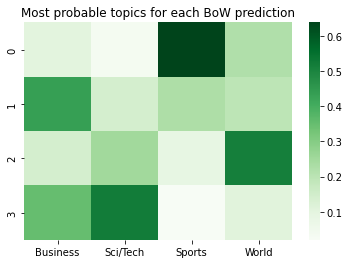

In [54]:
import seaborn as sns
bow_labels = match_label(df.topic.values, df.bow_pred.values, name_mapping)
sns.heatmap(bow_labels, cmap='Greens')
plt.title('Most probable topics for each BoW prediction')
plt.show()

In [55]:
bow_mapping = {}
for idx, row in enumerate(bow_labels.values):
    print(f'Topic {idx}: {bow_labels.columns[row.argmax()]} with accuracy {row.max():.3f}')
    bow_mapping[idx] = bow_labels.columns[row.argmax()]

Topic 0: Sports with accuracy 0.638
Topic 1: Business with accuracy 0.435
Topic 2: World with accuracy 0.515
Topic 3: Sci/Tech with accuracy 0.522


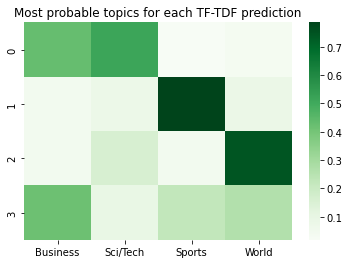

In [56]:
tfidf_labels = match_label(df.topic.values, df.tfidf_pred.values, name_mapping)
sns.heatmap(tfidf_labels, cmap='Greens')
plt.title('Most probable topics for each TF-TDF prediction')
plt.show()

In [57]:
tfidf_mapping = {}
for idx, row in enumerate(tfidf_labels.values):
    print(f'Topic {idx}: {tfidf_labels.columns[row.argmax()]} with accuracy {row.max():.3f}')
    tfidf_mapping[idx] = bow_labels.columns[row.argmax()]

Topic 0: Sci/Tech with accuracy 0.515
Topic 1: Sports with accuracy 0.786
Topic 2: World with accuracy 0.745
Topic 3: Business with accuracy 0.417


It's good to see that the numbers match exactly what we have intuitively guessed what each topic labeled by LDA mean, although the accuracy in each class is quite bad.

## 3.3 Evaluation

In [ ]:
df['topic'] = df['topic'].map(name_mapping)
df['bow_pred'] = df['bow_pred'].map(bow_mapping)
df['tfidf_pred'] = df['tfidf_pred'].map(tfidf_mapping)

In [65]:
df[['topic', 'bow_pred' ,'tfidf_pred']]

,topic,bow_pred,tfidf_pred
0,Business,World,Business
1,Business,Sci/Tech,Business
2,Business,Business,Sci/Tech
3,Business,World,World
4,Business,Sports,World
...,...,...,...
7595,World,World,World
7596,Sports,Business,Business
7597,Sports,Business,Sports
7598,Business,Business,Business


In [70]:
bow_acc = sum([1 if x[0]==x[1] else 0 for x in df[['topic', 'bow_pred']].values])/len(df)
tfidf_acc = sum([1 if x[0]==x[1] else 0 for x in df[['topic', 'tfidf_pred']].values])/len(df)
print(f'Accuracy for BoW LDA model: {bow_acc:.3f}')
print(f'Accuracy for TF-IDF LDA model: {tfidf_acc:.3f}')

Accuracy for BoW LDA model: 0.536
Accuracy for TF-IDF LDA model: 0.613


It's not amazing compared to using CNN on an embedded set of words, but it's doing pretty well considering that LDA has no idea what each word or even each topic means. It is clustering based on words distribution alone which is pretty cool. <br>
There are some cool new things these days like lda2vec that does lda using pre-trained embedded vectors, maybe I'll look into that next.